# ctscan_mobilenetV2

Source: https://www.kaggle.com/code/ahmedtronic/covid-19-binary-classification-densenet169-98

## Import Libraries

In [1]:
import os
import random
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from torch import optim
from torchvision import models, datasets

import warnings
warnings.filterwarnings("ignore")

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='cuda')

## Helper Functions

In [3]:
def learning_curves_tuning(train_loss, valid_loss, train_acc, valid_acc,
                           fine_tune_epoch=None):
    
    # Get training and validation data from initial training
    tacc = train_acc
    tloss = train_loss
    vacc = valid_acc
    vloss = valid_loss

    total_epochs = [i+1 for i in range(len(tacc))]

    # Find best epoch based on validation loss and accuracy
    index_loss = np.argmin(vloss)  # epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    
    index_acc = np.argmax(vacc)  # epoch with the highest validation accuracy
    acc_highest = vacc[index_acc]

    # Define plot labels
    sc_label = 'best epoch= ' + str(index_loss + 1)
    vc_label = 'best epoch= ' + str(index_acc + 1)

    plt.style.use('fivethirtyeight')
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Plot loss curves
    axes[0].plot(total_epochs, tloss, 'r', label='Training Loss')
    axes[0].plot(total_epochs, vloss, 'g', label='Validation Loss')
    axes[0].scatter(index_loss + 1, val_lowest, s=150, c='blue', label=sc_label)

    # Add fine-tuning marker
    if fine_tune_epoch:
        axes[0].axvline(x=fine_tune_epoch, color='orange', linestyle='--',
                        label='Start Fine Tuning')

    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_ylim(0, 1)
    axes[0].legend()

    # Plot accuracy curves
    axes[1].plot(total_epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(total_epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1, acc_highest, s=150, c='blue', label=vc_label)

    # Add fine-tuning marker
    if fine_tune_epoch:
        axes[1].axvline(x=fine_tune_epoch, color='orange', linestyle='--',
                        label='Start Fine Tuning')

    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [4]:
def train_epoch(model):
    model.train()
    epoch_loss = 0
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #forward path
        output = model(images)
        loss = criterion(output, labels)
        epoch_loss += loss.item()
        
        _, predicted = torch.max(output, 1)
        total_correct += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
                
        #bacward path
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_number and batch_number % 50 == 0):
            current_loss = epoch_loss / (batch_number + 1)
            current_acc = total_correct / total_predictions
            print(f"Batch [{batch_number}/{len(train_loader)}], Loss:{current_loss:0.6f}, Accuracy: {current_acc*100:.3f}%")
            
    avg_loss = epoch_loss / len(train_loader)
    avg_acc = total_correct / total_predictions
    
    return avg_loss, avg_acc

In [5]:
def get_val(model):
    model.eval()
    epoch_loss = 0
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
    # no gradient cal for tensor, same for: requires_grad = False and detach()
        for batch_num, (images, labels) in enumerate(valid_loader):
    
            images = images.to(device)
            labels = labels.to(device)
            
            #forward path
            output = model(images)
            loss = criterion(output, labels)
            epoch_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total_correct += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
    avg_loss = epoch_loss / len(valid_loader)
    avg_acc = total_correct / total_predictions

    return avg_loss, avg_acc

In [6]:
def get_test(device, model, test_loader):
    """
    Calculates the test loss and accuracy for the given model.

    Parameters:
    - model: Trained model for evaluation.
    
    Returns:
    - test_loss: Average test loss over the test dataset.
    - test_accuracy: Test accuracy over the test dataset.
    """
    model.eval()
    epoch_loss = 0
    total_correct = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_num, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            _, predicted = torch.max(output, 1)
            loss = criterion(output, labels)
            epoch_loss += loss.item()

            total_correct += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    # Average test loss
    avg_loss = epoch_loss / len(test_loader)
    avg_acc = total_correct / total_predictions
    
    return avg_loss, avg_acc
    

In [7]:
def get_predict(model, data_loader, device):
    """
    Get all predictions and true labels from the data loader.

    Parameters:
    - model: Trained model for predictions.
    - data_loader: DataLoader for the dataset.

    Returns:
    - y_true: List of true labels.
    - y_pred: List of predicted labels.
    """
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch_num, (images, labels) in enumerate(data_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

## Load Data

In [8]:
dataset_dir = "datasets/ctscan/raw"
covid_dir = "datasets/ctscan/raw/COVID"
non_covid_dir = "datasets/ctscan/raw/non-COVID"

image_size = (224, 224)
dataset = datasets.ImageFolder(root=dataset_dir)
class_names = dataset.classes
num_classes = len(class_names)
class_names

['COVID', 'non-COVID']

In [9]:
dataset_paths = glob.glob(f"{dataset_dir}/**/*.png")
covid_paths = glob.glob(f"{covid_dir}/*.png")
non_covid_paths = glob.glob(f"{non_covid_dir}/*.png")

print("Total:", len(dataset_paths))
print("Covid:", len(covid_paths))
print("Non-Covid:", len(non_covid_paths))

Total: 2481
Covid: 1252
Non-Covid: 1229


In [10]:
train_paths, test_paths = train_test_split(dataset_paths, test_size=0.15, random_state=42)

In [11]:
val_paths, test_paths = train_test_split(test_paths, test_size=0.5, random_state=42)

In [12]:
print("Train:", len(train_paths))
print("Val:", len(val_paths))
print("Test:", len(test_paths))

Train: 2108
Val: 186
Test: 187


In [13]:
covid_path = os.path.join("COVID", "Covid")

# Count the number of covid and non_covid in the validation set
train_covid_count = len([path for path in train_paths if covid_path in path])
train_non_covid_count = len([path for path in train_paths if "Non-Covid" in path])

# Count the number of covid and non_covid in the validation set
valid_covid_count = len([path for path in val_paths if covid_path in path])
valid_non_covid_count = len([path for path in val_paths if "Non-Covid" in path])

# Count the number of covid and non_covid in the test set
test_covid_count = len([path for path in test_paths if covid_path in path])
test_non_covid_count = len([path for path in test_paths if "Non-Covid" in path])

# Print the counts
print("Train set - Covid:", train_covid_count)
print("Train set - Non-Covid:", train_non_covid_count)
print("Validation set - Covid:", valid_covid_count)
print("Validation set - Non-Covid:", valid_non_covid_count)
print("Test set - Covid:", test_covid_count)
print("Test set - Non-Covid:", test_non_covid_count)

Train set - Covid: 1075
Train set - Non-Covid: 1033
Validation set - Covid: 86
Validation set - Non-Covid: 100
Test set - Covid: 91
Test set - Non-Covid: 96


In [14]:
torch.manual_seed(42)
random.seed(42)
random.shuffle(train_paths)

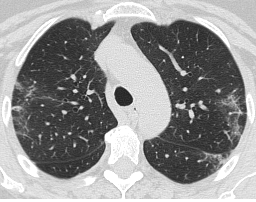

In [15]:
img = Image.open(covid_paths[0])
img

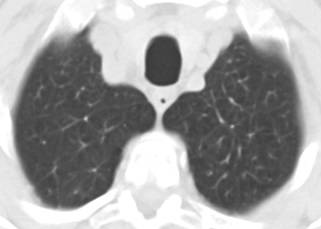

In [16]:
img = Image.open(non_covid_paths[0])
img

## Data Augmentation & Preprocessing

In [17]:
train_transform = v2.Compose([
    v2.Resize(image_size),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p = 0.5), # 50 % from images will apply to
    v2.RandomVerticalFlip(p = 0.5), # 50 % from images will apply to
    v2.RandomRotation(10),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = v2.Compose([
    v2.Resize(image_size),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = {
    "train_transform":train_transform,
    "valid_transform":valid_transform
}

In [18]:
class CovidDataset(Dataset):
    def __init__(self, paths, transform = None, is_train =True):
        # data loadig
        self.paths = paths
        self.transform = transform
        self.is_train = is_train

    def __getitem__(self, index):
        img = Image.open(self.paths[index])
        img = img.convert("RGB") # Some images 4 channels
        label = self.paths[index][-15:-10]

        if self.transform:
            if self.is_train:
                img = self.transform["train_transform"](img)
            else:
                img = self.transform["valid_transform"](img)
        
        return img, (1 if label == "Covid" else 0)
        
    def __len__(self):
        return len(self.paths)

In [19]:
train_data = CovidDataset(train_paths, transform)
valid_data = CovidDataset(val_paths, transform, is_train=False)
test_data = CovidDataset(test_paths, transform, is_train=False)

In [20]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=16)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=16)
test_loader = DataLoader(test_data, shuffle=False, batch_size=16)

In [21]:
next(iter(train_loader))[0].shape # images must have the same size

torch.Size([16, 3, 224, 224])

In [22]:
next(iter(train_loader))[1]

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


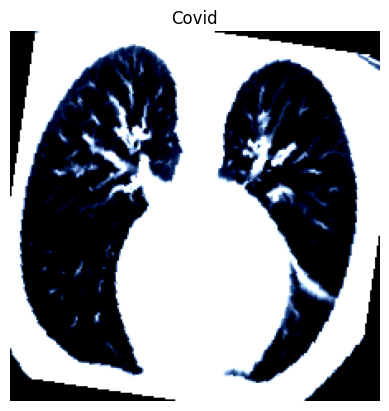

In [23]:
img = train_data[1][0]
plt.grid(False)
plt.axis(False)
plt.title("Covid" if train_data[1][1] == 1 else "Non-Covid")
plt.imshow(img.permute(1,2,0)); # img in tensor[channels, h, w]
# matplolib needs it [h, w, channels] so we use permute

## MobileNetV2

### Transfer Learning

In [24]:
net = models.mobilenet_v2(weights='IMAGENET1K_V1')

In [25]:
for parameter in net.parameters():
    parameter.requires_grad = False

net.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [26]:
net.last_channel

1280

In [27]:
net.classifier = nn.Sequential(
    nn.Linear(net.last_channel, 512),  # Example: Add a fully connected layer
    nn.Dropout(p=0.5),
    nn.Linear(512, num_classes)  # Final output layer for binary classification (COVID vs. non-COVID)
)

net = net.to(device)

In [28]:
# Early stopping parameters
best_score = float("inf") # ModelCheckpoint
patience = 0 # EarlyStopping

initial_epochs = 20  # Number of epochs before fine-tuning
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.classifier.parameters(), lr=1e-3, weight_decay=0.01)

In [29]:
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

# train loop

for epoch in range(initial_epochs):
    print(f"Epoch[{epoch+1}/{initial_epochs}],    ", end="")

    avg_train_loss, train_acc = train_epoch(net)
    avg_valid_loss, valid_acc = get_val(net)

    # ModelCheckpoint & Save best model 
    if (avg_valid_loss < best_score):
        best_score = avg_valid_loss
        torch.save(net.state_dict(), f"model_net.pth")
        patience = 0
        
    # EarlyStopping
    else:
        patience += 1
        if (patience >= 10):
            print(f"Early stopping triggered after {epoch} epochs during training.")
            break
        
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f'Train Loss = {avg_train_loss:.6f} -- Train Accuracy = {train_acc*100:2.3f}%')
    print(f'Validation Loss = {avg_valid_loss:.6f} -- Validation Accuracy = {valid_acc*100:2.3f}%')
    print(" ")

Epoch[1/20],    Batch [50/132], Loss:0.931564, Accuracy: 63.603%
Batch [100/132], Loss:0.802476, Accuracy: 65.161%
Train Loss = 0.770447 -- Train Accuracy = 66.082%
Validation Loss = 0.564674 -- Validation Accuracy = 74.194%
 
Epoch[2/20],    Batch [50/132], Loss:0.554441, Accuracy: 73.284%
Batch [100/132], Loss:0.567986, Accuracy: 71.968%
Train Loss = 0.573186 -- Train Accuracy = 71.774%
Validation Loss = 0.549036 -- Validation Accuracy = 73.118%
 
Epoch[3/20],    Batch [50/132], Loss:0.637376, Accuracy: 68.382%
Batch [100/132], Loss:0.599213, Accuracy: 70.916%
Train Loss = 0.591130 -- Train Accuracy = 71.490%
Validation Loss = 0.583810 -- Validation Accuracy = 69.892%
 
Epoch[4/20],    Batch [50/132], Loss:0.588764, Accuracy: 71.936%
Batch [100/132], Loss:0.575171, Accuracy: 73.082%
Train Loss = 0.581846 -- Train Accuracy = 71.869%
Validation Loss = 0.598255 -- Validation Accuracy = 72.043%
 
Epoch[5/20],    Batch [50/132], Loss:0.537180, Accuracy: 73.652%
Batch [100/132], Loss:0.547

## Fine-Tuning

In [30]:
# net.features

In [31]:
for parameter in net.features[-6:].parameters():
    parameter.requires_grad = True

In [32]:
# Lower learning rate for fine-tuning
optimizer = optim.Adam(net.parameters(), lr=3e-5, weight_decay=0.01)

# Early stopping parameters
best_score = float("inf") # ModelCheckpoint
patience = 0 # EarlyStopping
fine_tuning_epochs = 50  # number of fine-tuning epochs

In [33]:
# train loop

for epoch in range(fine_tuning_epochs):
    print(f"Epoch[{epoch+1}/{fine_tuning_epochs}],    ", end="")

    avg_train_loss, train_acc = train_epoch(net)
    avg_valid_loss, valid_acc = get_val(net)


    # ModelCheckpoint & Save best model 
    if (avg_valid_loss < best_score):
        best_score = avg_valid_loss
        torch.save(net.state_dict(), f"model_net_finetuned.pth")
        patience = 0
        
    # EarlyStopping Callback
    else:
        patience += 1
        if (patience >= 10):
            print(f"Early stopping triggered after {epoch} epochs during training.")
            break
    
        
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f'Train Loss = {avg_train_loss:.6f} -- Train Accuracy = {train_acc*100:2.3f}%')
    print(f'Validation Loss = {avg_valid_loss:.6f} -- Validation Accuracy = {valid_acc*100:2.3f}%')
    print(" ")

Epoch[1/50],    Batch [50/132], Loss:0.512780, Accuracy: 76.838%
Batch [100/132], Loss:0.512208, Accuracy: 75.743%
Train Loss = 0.511846 -- Train Accuracy = 75.854%
Validation Loss = 0.530007 -- Validation Accuracy = 73.118%
 
Epoch[2/50],    Batch [50/132], Loss:0.481099, Accuracy: 76.471%
Batch [100/132], Loss:0.465136, Accuracy: 77.290%
Train Loss = 0.461237 -- Train Accuracy = 77.609%
Validation Loss = 0.462719 -- Validation Accuracy = 78.495%
 
Epoch[3/50],    Batch [50/132], Loss:0.424627, Accuracy: 79.902%
Batch [100/132], Loss:0.415513, Accuracy: 81.064%
Train Loss = 0.409737 -- Train Accuracy = 81.499%
Validation Loss = 0.410331 -- Validation Accuracy = 82.258%
 
Epoch[4/50],    Batch [50/132], Loss:0.370769, Accuracy: 83.701%
Batch [100/132], Loss:0.390517, Accuracy: 82.611%
Train Loss = 0.391983 -- Train Accuracy = 82.353%
Validation Loss = 0.352098 -- Validation Accuracy = 87.097%
 
Epoch[5/50],    Batch [50/132], Loss:0.349194, Accuracy: 85.172%
Batch [100/132], Loss:0.347

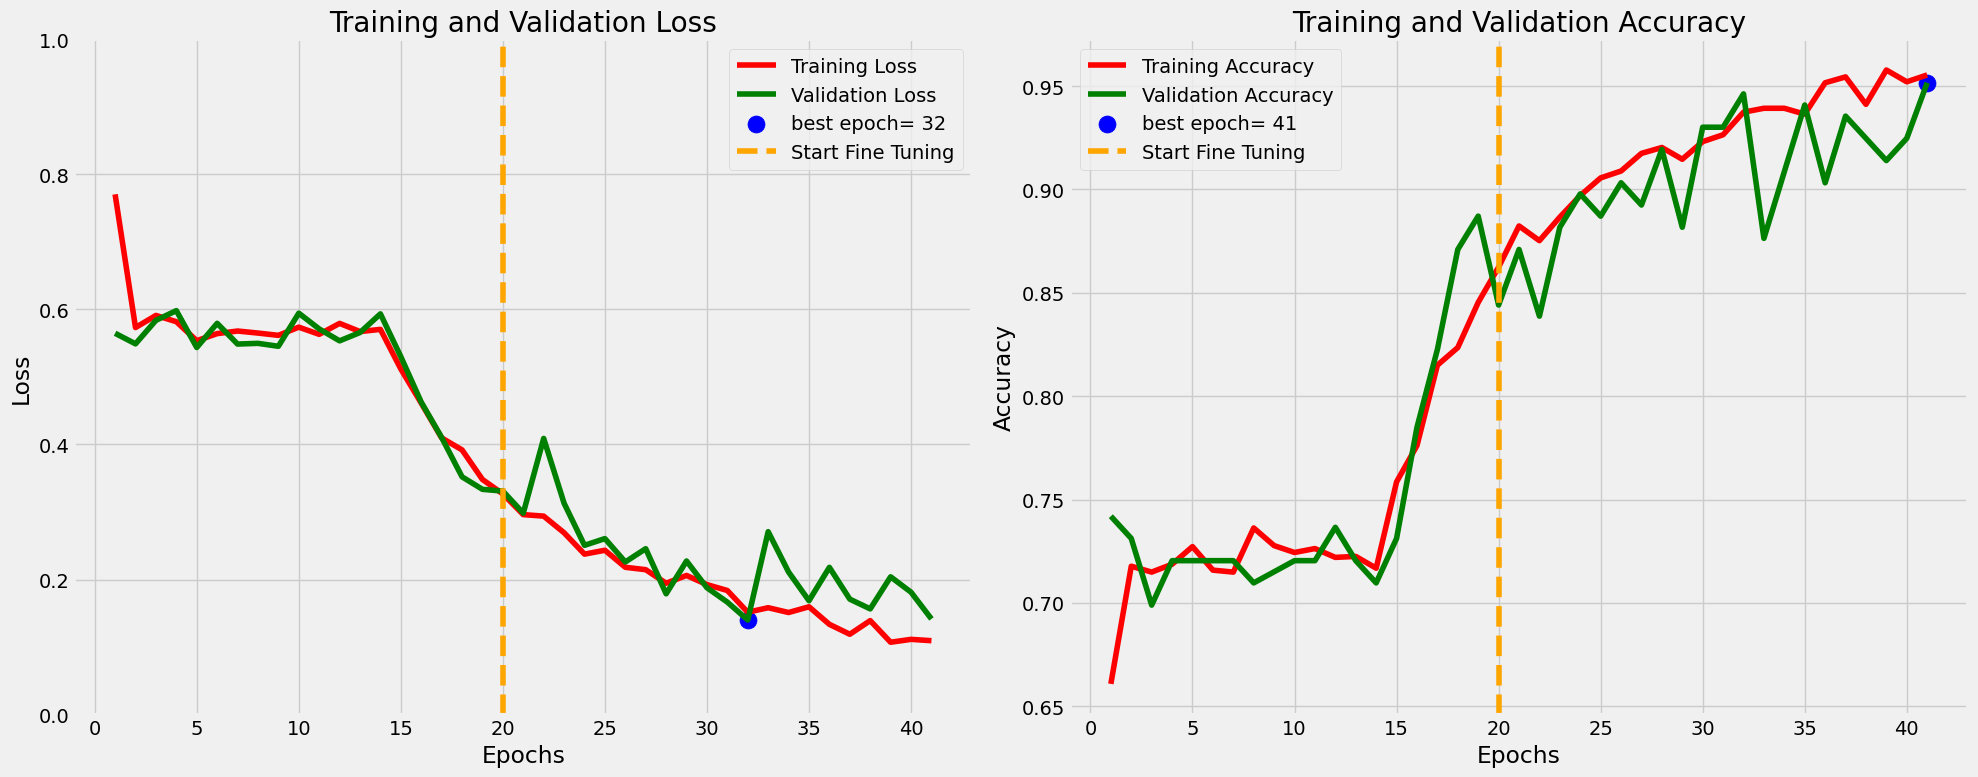

In [34]:
learning_curves_tuning(train_losses, valid_losses, train_accs, valid_accs, fine_tune_epoch=initial_epochs)

In [29]:
net.load_state_dict(torch.load("model_net_finetuned.pth", weights_only=True))

<All keys matched successfully>

In [30]:
validation_loss, validation_accuracy = get_val(net)
print(f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy*100:.2f}%')

Validation Loss: 0.1401, Validation Accuracy: 94.62%


In [31]:
test_loss, test_accuracy = get_test(device, net, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%')

Test Loss: 0.2530, Test Accuracy: 88.77%


## Classification Report & Confusion Matrix

In [32]:
y_true, y_pred = get_predict(net, test_loader, device)
print(classification_report(y_true, y_pred, target_names= class_names))

              precision    recall  f1-score   support

       COVID       0.76      0.84      0.80        50
   non-COVID       0.94      0.91      0.92       137

    accuracy                           0.89       187
   macro avg       0.85      0.87      0.86       187
weighted avg       0.89      0.89      0.89       187



(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

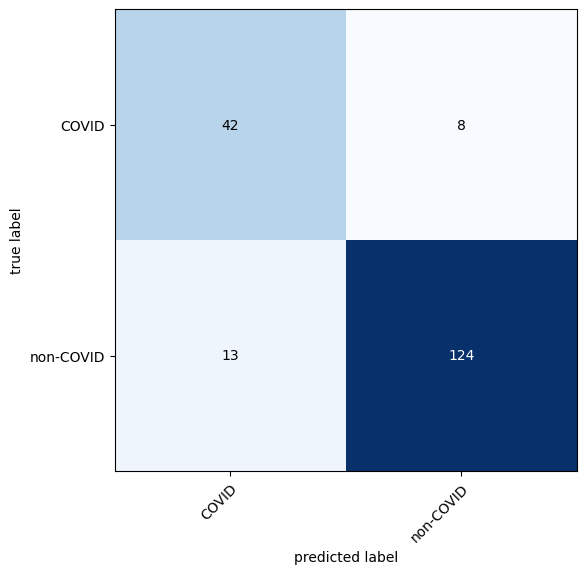

In [33]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names=class_names, figsize=(8,6))

Calculating image metrics...
Calculating datasets/ctscan/raw/
Avg SSIM: 1.0
Avg PSNR (dB): inf
Calculating datasets/ctscan/krawtchouk_0.500_0.500_50/
Avg SSIM: 0.9880223887350053
Avg PSNR (dB): 42.098870837119556
Calculating datasets/ctscan/krawtchouk_0.500_0.500_100/
Avg SSIM: 0.963324331211502
Avg PSNR (dB): 36.5937667937779
Calculating datasets/ctscan/krawtchouk_0.500_0.500_200/
Avg SSIM: 0.9106539450587787
Avg PSNR (dB): 31.21793619218308
Calculating datasets/ctscan/krawtchouk_0.500_0.500_300/
Avg SSIM: 0.868889201680985
Avg PSNR (dB): 28.401041561964874
Calculating datasets/ctscan/roni/
Avg SSIM: 0.9999411375552179
Avg PSNR (dB): 68.40680202908825
Calculating datasets/ctscan/guo_zhuang/
Avg SSIM: 0.9988164046845046
Avg PSNR (dB): 52.39488674786424
Finished calculating image metrics.

Calculating performance metrics...
Testing raw
Test Loss: 0.2530, Test Accuracy: 88.77%
              precision    recall  f1-score   support

       COVID       0.76      0.84      0.80        50
   

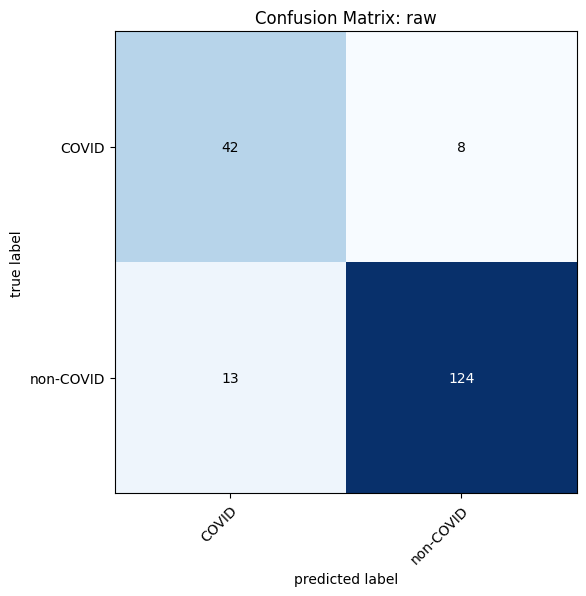

Testing krawtchouk p1=0.500 p2=0.500 strength=50
Test Loss: 0.2818, Test Accuracy: 87.17%
              precision    recall  f1-score   support

       COVID       0.80      0.70      0.74        50
   non-COVID       0.90      0.93      0.91       137

    accuracy                           0.87       187
   macro avg       0.85      0.82      0.83       187
weighted avg       0.87      0.87      0.87       187



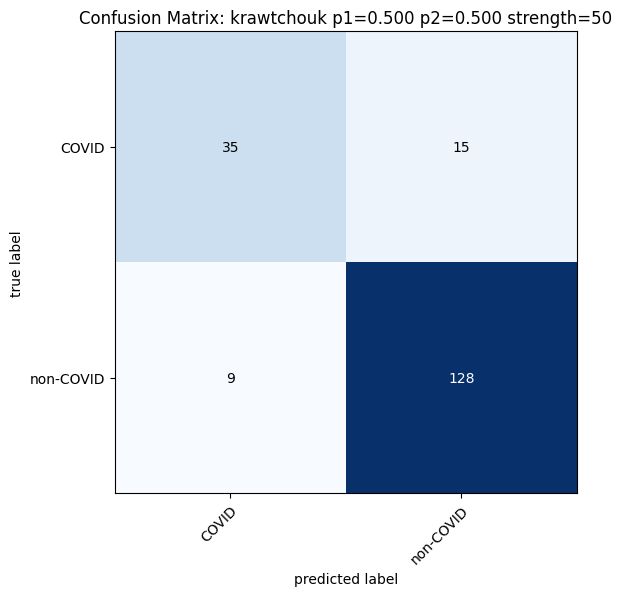

Testing krawtchouk p1=0.500 p2=0.500 strength=100
Test Loss: 0.3631, Test Accuracy: 84.49%
              precision    recall  f1-score   support

       COVID       0.76      0.62      0.68        50
   non-COVID       0.87      0.93      0.90       137

    accuracy                           0.84       187
   macro avg       0.81      0.77      0.79       187
weighted avg       0.84      0.84      0.84       187



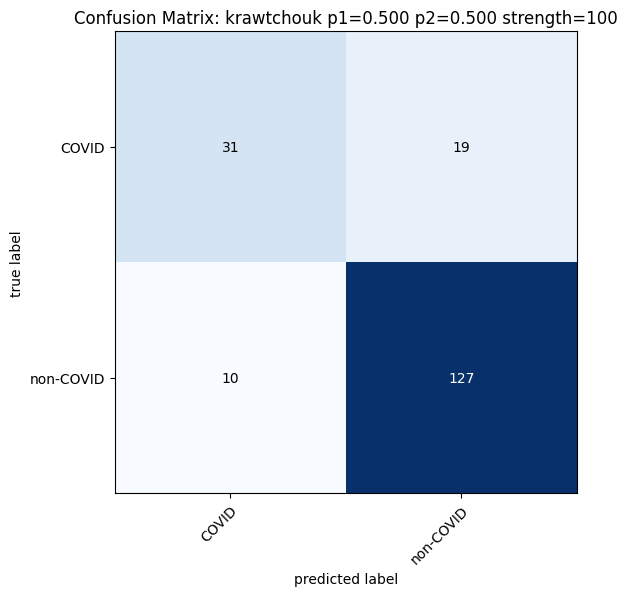

Testing krawtchouk p1=0.500 p2=0.500 strength=200
Test Loss: 0.5538, Test Accuracy: 80.75%
              precision    recall  f1-score   support

       COVID       0.69      0.50      0.58        50
   non-COVID       0.83      0.92      0.88       137

    accuracy                           0.81       187
   macro avg       0.76      0.71      0.73       187
weighted avg       0.80      0.81      0.80       187



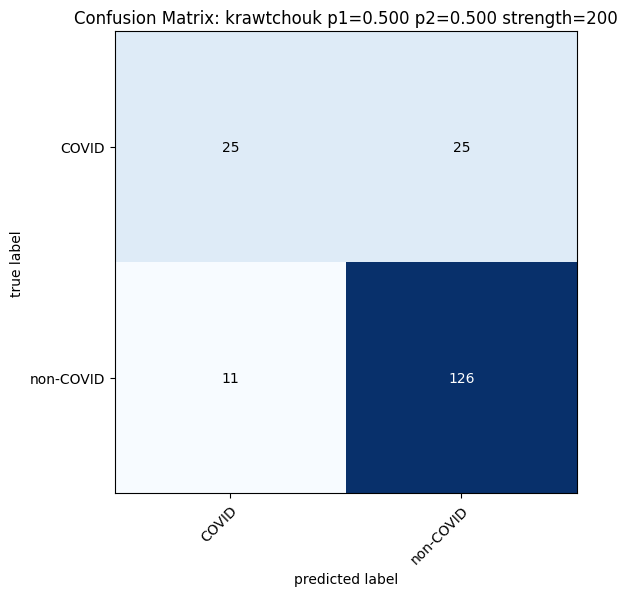

Testing krawtchouk p1=0.500 p2=0.500 strength=300
Test Loss: 0.6531, Test Accuracy: 77.54%
              precision    recall  f1-score   support

       COVID       0.65      0.34      0.45        50
   non-COVID       0.80      0.93      0.86       137

    accuracy                           0.78       187
   macro avg       0.72      0.64      0.65       187
weighted avg       0.76      0.78      0.75       187



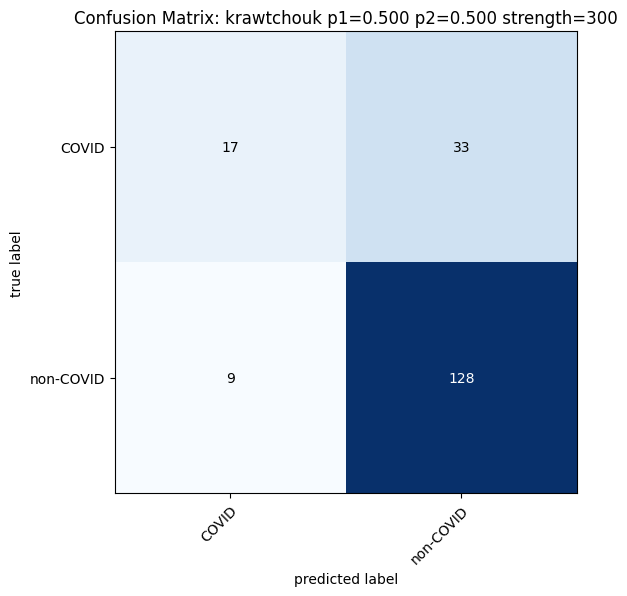

Testing roni
Test Loss: 0.2530, Test Accuracy: 88.77%
              precision    recall  f1-score   support

       COVID       0.76      0.84      0.80        50
   non-COVID       0.94      0.91      0.92       137

    accuracy                           0.89       187
   macro avg       0.85      0.87      0.86       187
weighted avg       0.89      0.89      0.89       187



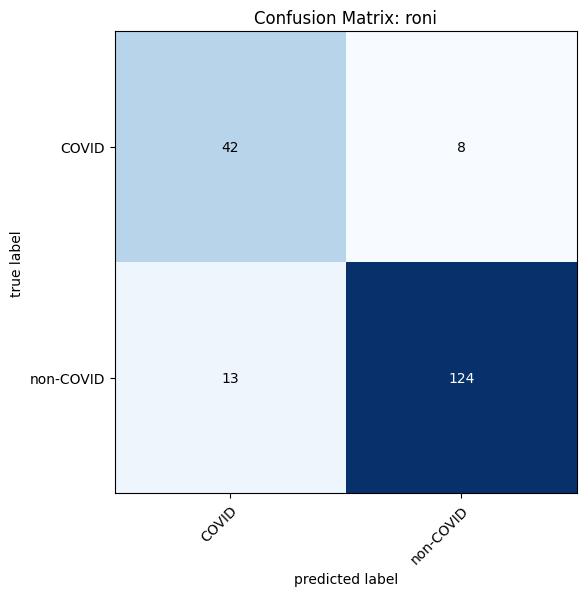

Testing guo_zhuang
Test Loss: 0.2476, Test Accuracy: 88.77%
              precision    recall  f1-score   support

       COVID       0.77      0.82      0.80        50
   non-COVID       0.93      0.91      0.92       137

    accuracy                           0.89       187
   macro avg       0.85      0.87      0.86       187
weighted avg       0.89      0.89      0.89       187



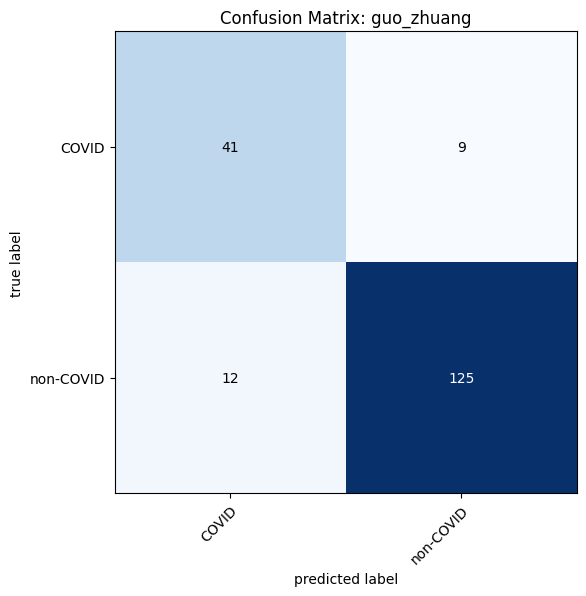

Finished calculating performance metrics.


,Name,Strength,Position,L-Bits,Mean SSIM,Stdev SSIM,Mean PSNR (dB),Stdev PSNR (dB),Accuracy,Precision,Recall,F1 Score,Number of Test Images,True Positives,False Negatives,True Negatives,False Positives
0,Unaltered,N/A,N/A,N/A,1.000000,0.000000,∞,Undefined,0.887701,0.939394,0.905109,0.921933,187,42,8,124,13
1,Krawtchouk,50,"(0.5, 0.5)",1024,0.988022,0.006002,42.098871,1.422523,0.871658,0.895105,0.934307,0.914286,187,35,15,128,9
2,Krawtchouk,100,"(0.5, 0.5)",1024,0.963324,0.016687,36.593767,1.426785,0.844920,0.869863,0.927007,0.897527,187,31,19,127,10
3,Krawtchouk,200,"(0.5, 0.5)",1024,0.910654,0.033500,31.217936,1.416527,0.807487,0.834437,0.919708,0.875000,187,25,25,126,11
4,Krawtchouk,300,"(0.5, 0.5)",1024,0.868889,0.042312,28.401042,1.389842,0.775401,0.795031,0.934307,0.859060,187,17,33,128,9
5,RONI,N/A,N/A,1024,0.999941,0.000031,68.406802,1.527335,0.887701,0.939394,0.905109,0.921933,187,42,8,124,13
6,Guo-Zhuang,N/A,N/A,75,0.998816,0.000929,52.394887,11.87593,0.887701,0.932836,0.912409,0.922509,187,41,9,125,12


In [34]:
import shared_util
import importlib
importlib.reload(shared_util)

report = shared_util.ModelPerformanceReport()
report.evaluate(device, net, criterion)
report.df

In [37]:
report.df[["Name", "Strength", "Position", "L-Bits", "Mean SSIM", "Mean PSNR (dB)", "Accuracy", "Precision", "Recall", "F1 Score"]]

,Name,Strength,Position,L-Bits,Mean SSIM,Mean PSNR (dB),Accuracy,Precision,Recall,F1 Score
0,Unaltered,N/A,N/A,N/A,1.000000,∞,0.887701,0.939394,0.905109,0.921933
1,Krawtchouk,50,"(0.5, 0.5)",1024,0.988022,42.098871,0.871658,0.895105,0.934307,0.914286
2,Krawtchouk,100,"(0.5, 0.5)",1024,0.963324,36.593767,0.844920,0.869863,0.927007,0.897527
3,Krawtchouk,200,"(0.5, 0.5)",1024,0.910654,31.217936,0.807487,0.834437,0.919708,0.875000
4,Krawtchouk,300,"(0.5, 0.5)",1024,0.868889,28.401042,0.775401,0.795031,0.934307,0.859060
5,RONI,N/A,N/A,1024,0.999941,68.406802,0.887701,0.939394,0.905109,0.921933
6,Guo-Zhuang,N/A,N/A,75,0.998816,52.394887,0.887701,0.932836,0.912409,0.922509


In [36]:
report.df[["Name", "Strength", "Position", "L-Bits", "Number of Test Images", "True Positives", "False Negatives", "True Negatives", "False Positives"]]

,Name,Strength,Position,L-Bits,Number of Test Images,True Positives,False Negatives,True Negatives,False Positives
0,Unaltered,N/A,N/A,N/A,187,42,8,124,13
1,Krawtchouk,50,"(0.5, 0.5)",1024,187,35,15,128,9
2,Krawtchouk,100,"(0.5, 0.5)",1024,187,31,19,127,10
3,Krawtchouk,200,"(0.5, 0.5)",1024,187,25,25,126,11
4,Krawtchouk,300,"(0.5, 0.5)",1024,187,17,33,128,9
5,RONI,N/A,N/A,1024,187,42,8,124,13
6,Guo-Zhuang,N/A,N/A,75,187,41,9,125,12
